In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, plot_roc_curve, recall_score, f1_score, classification_report

import mlflow
import mlflow.sklearn

## 1. Preprocessing as previous work

In [2]:
df = pd.read_csv('creditcard.csv')
df = df.drop('Time',axis = 1)

In [3]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [31]:
# only use 1%
normal = df[df.Class == 0].sample(frac=0.003, random_state=2022).reset_index(drop=True)
anomaly = df[df.Class == 1]
print(f"Normal: {normal.shape}")
print(f"Anomaly: {anomaly.shape}")

Normal: (853, 30)
Anomaly: (492, 30)


In [32]:
# 6:2:2
normal_train, normal_test = train_test_split(normal,test_size = 0.4, random_state = 2022)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size = 0.4, random_state = 2022)
normal_val, normal_test = train_test_split(normal_test,test_size = 0.5, random_state = 2022)
anomaly_val, anomaly_test = train_test_split(anomaly_test, test_size = 0.5, random_state = 2022)

In [33]:
x_train = pd.concat((normal_train, anomaly_train))
x_test = pd.concat((normal_test, anomaly_test))
x_val = pd.concat((normal_val, anomaly_val))
y_train = np.array(x_train["Class"])
y_test = np.array(x_test["Class"])
y_val = np.array(x_val["Class"])
x_train = x_train.drop("Class", axis=1)
x_test = x_test.drop("Class", axis=1)
x_val = x_val.drop("Class", axis=1)

In [34]:
scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop("Class", axis=1))
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

## 2. Training and Evaluating

In [35]:
def train(sk_model, x_train, y_train):
    sk_model = sk_model.fit(x_train, y_train)
    train_acc = sk_model.score(x_train, y_train)
    mlflow.log_metric("train_acc", train_acc) # MLflow에게 log전달
    print(f"Train Accuracy: {train_acc:.3%}")


In [36]:
def evaluate(sk_model, x_test, y_test):
    eval_acc = sk_model.score(x_test, y_test)
    preds = sk_model.predict(x_test)
    auc_score = roc_auc_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    recall = recall_score(y_test, preds)
    mlflow.log_metric("eval_acc", eval_acc)
    mlflow.log_metric("auc_score", auc_score) # add other metrics to follow
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("recall", recall)
    print(f"Auc Score: {auc_score:.3%}")
    print(f"f1 Score: {f1:.3%}")
    print(f"recall Score: {recall:.3%}")
    print(f"Eval Accuracy: {eval_acc:.3%}")
    roc_plot = plot_roc_curve(sk_model, x_test, y_test, name='Scikit-learn ROC Curve')
    plt.savefig("sklearn_roc_plot.png")
    plt.show()
    plt.clf()
    conf_matrix = confusion_matrix(y_test, preds)
    ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
    #ax.invert_xaxis()
    #ax.invert_yaxis()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("Confusion Matrix")
    plt.savefig("sklearn_conf_matrix.png")
    mlflow.log_artifact("sklearn_roc_plot.png")
    mlflow.log_artifact("sklearn_conf_matrix.png")

Train Accuracy: 96.278%
Auc Score: 94.577%
f1 Score: 93.750%
recall Score: 90.909%
Eval Accuracy: 95.556%


/Users/captain/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


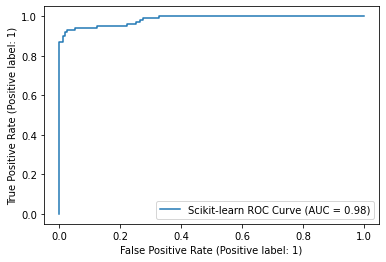

Model run:  7f792ebf8ce24b1e98cd66feacf5385d


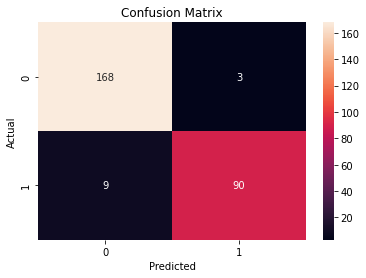

In [37]:
sk_model = LogisticRegression(random_state=None, max_iter=400, solver='newton-cg', C = 15)
mlflow.set_experiment("scikit_learn_experiment")
with mlflow.start_run():
    train(sk_model, x_train, y_train)
    evaluate(sk_model, x_test, y_test)
    mlflow.sklearn.log_model(sk_model, "log_reg_model_under") # model name
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()

now go to terminal and type \
mlflow ui -p 1234 \
Then go to http://localhost:1234

### Load logged model 

In [40]:
loaded_model = mlflow.sklearn.load_model('runs:/7f792ebf8ce24b1e98cd66feacf5385d/log_reg_model_under')
# format / ID / modelName

In [41]:
y_pred = loaded_model.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       171
           1       0.97      0.91      0.94        99

    accuracy                           0.96       270
   macro avg       0.96      0.95      0.95       270
weighted avg       0.96      0.96      0.96       270



## 3. Hyperparameter Tuning

In [43]:
anomaly_weights = [1, 5, 10, 15, 30]
num_folds = 5
kfold = KFold(n_splits = num_folds, shuffle = True, random_state = 2022)

In [48]:
mlflow.set_experiment('log_reg_search')
logs = []
for f in range(len(anomaly_weights)):
    fold = 1
    accuracies = []
    auc_scores = []
    f1_scores = []
    recall_scores = []
    for train, test in kfold.split(x_val,y_val):
        with mlflow.start_run():
            weight = anomaly_weights[f]
            mlflow.log_param('anomaly_weight', weight)
            class_weights = {
                0:1,
                1:weight
            }
            sk_model = LogisticRegression(random_state = None, max_iter=400, solver='newton-cg', C = 15,
                                         class_weight = class_weights).fit(x_val[train], y_val[train])
            for h in range(40): print('-',end='')
            print(f"\nfold {fold}\nAnomaly Weight: {weight}")
            train_acc = sk_model.score(x_val[train], y_val[train])
            mlflow.log_metric("train_acc", train_acc)
            eval_acc = sk_model.score(x_val[test], y_val[test])
            preds = sk_model.predict(x_val[test])
            mlflow.log_metric("eval_acc", eval_acc)
            
            # exceptions
            try:
                auc_score = roc_auc_score(y_val[test], preds)
                recall = recall_score(y_val[test], preds)
                f1 = f1_score(y_val[test], preds)
            except:
                auc_score = -1
                recall = -1
                f1 = -1
                print('***Something Wrong with the result***')
            # make logs
            mlflow.log_metric('auc_score', auc_score)
            mlflow.log_metric('f1_score', f1)
            mlflow.log_metric('recall_score', recall)
            print("AUC: {}\neval_acc: {}\nf1_score: {}\nrecall_score: {}".format(auc_score,eval_acc,f1,recall))
            
            accuracies.append(eval_acc)
            auc_scores.append(auc_score)
            f1_scores.append(f1)
            recall_scores.append(recall)
            
            log = [sk_model, x_val[test], y_val[test], preds]
            logs.append(log)
            mlflow.sklearn.log_model(sk_model, f"anom_weight_{weight}_fold_{fold}")
            
            fold += 1
            mlflow.end_run()
    # for each anomaly weights
    print("\nAverages: ")
    print("Accuracy: ", np.mean(accuracies))
    print("AUC: ", np.mean(auc_scores))
    print("f1: ", np.mean(f1_scores))
    print("Recall: ", np.mean(recall_scores))

    print("Best: ")
    print("Accuracy: ", np.max(accuracies))
    print("AUC: ", np.max(auc_scores))
    print("f1: ", np.max(f1_scores))
    print("Recall: ", np.max(recall_scores))

            

----------------------------------------
fold 1
Anomaly Weight: 1
AUC: 0.8863636363636364
eval_acc: 0.9074074074074074
f1_score: 0.8717948717948718
recall_score: 0.7727272727272727
----------------------------------------
fold 2
Anomaly Weight: 1
AUC: 0.9027777777777777
eval_acc: 0.9074074074074074
f1_score: 0.8648648648648649
recall_score: 0.8888888888888888
----------------------------------------
fold 3
Anomaly Weight: 1
AUC: 0.9276629570747218
eval_acc: 0.9444444444444444
f1_score: 0.9090909090909091
recall_score: 0.8823529411764706
----------------------------------------
fold 4
Anomaly Weight: 1
AUC: 0.9291666666666668
eval_acc: 0.9259259259259259
f1_score: 0.9199999999999999
recall_score: 0.9583333333333334
----------------------------------------
fold 5
Anomaly Weight: 1
AUC: 0.9428104575163399
eval_acc: 0.9433962264150944
f1_score: 0.9142857142857143
recall_score: 0.9411764705882353

Averages: 
Accuracy:  0.925716282320056
AUC:  0.9177562990798285
f1:  0.896007272007272
Recall

In [49]:
#  http://localhost:1234/#/experiments/3 (number may differ)

In [50]:
# metrics.f1_score > 0.85 and metrics.recall_score > 0.9  (query)

## 4. AWS Sagemaker

In [51]:
import subprocess

In [53]:
# synchronize mlruns directory with bucket
s3_bucket_name = 'mlops-creditcard-runs'
mlruns_direc = './mlruns/'
output = subprocess.run(["aws", "s3", "sync", "{}".format(mlruns_direc), "s3://{}".format(s3_bucket_name)],
                        stdout=subprocess.PIPE, encoding='utf-8')
print(output.stdout)
print("\nSaved to bucket: ", s3_bucket_name)

Completed 146 Bytes/~21.8 KiB (2.6 KiB/s) with ~17 file(s) remaining (calculating...)
upload: mlruns/.trash/2/meta.yaml to s3://mlops-creditcard-runs/.trash/2/meta.yaml   
Completed 146 Bytes/~21.8 KiB (2.6 KiB/s) with ~17 file(s) remaining (calculating...)
Completed 181 Bytes/~64.8 KiB (1.8 KiB/s) with ~52 file(s) remaining (calculating...)
upload: mlruns/1/024dc913986e42d5af46160b6620e794/metrics/auc_score to s3://mlops-creditcard-runs/1/024dc913986e42d5af46160b6620e794/metrics/auc_score
Completed 181 Bytes/~64.8 KiB (1.8 KiB/s) with ~51 file(s) remaining (calculating...)
Completed 319 Bytes/~85.3 KiB (2.8 KiB/s) with ~58 file(s) remaining (calculating...)
upload: mlruns/0/meta.yaml to s3://mlops-creditcard-runs/0/meta.yaml                 
Completed 319 Bytes/~85.3 KiB (2.8 KiB/s) with ~57 file(s) remaining (calculating...)
Completed 418 Bytes/~86.4 KiB (3.3 KiB/s) with ~66 file(s) remaining (calculating...)
upload: mlruns/1/024dc913986e42d5af46160b6620e794/artifacts/log_reg_model/r

In [54]:
# build container
# mlflow sagemaker build-and-push-container
# you have to turn on the docker!

In [55]:
# execution_role: arn:aws:iam::aws:policy/AmazonSageMakerFullAccess
# app_name = 'Sagemaker-Creditcard'
# image_ecr_url: 354520713950.dkr.ecr.ap-northeast-2.amazonaws.com/mlflow-pyfunc:1.26.1
# region: ap-northeast-2
# model_uri: formating

## 5. Proceed deployment

In [66]:
import boto3
import mlflow.sagemaker as mfs
import json

app_name = 'Sagemaker-Creditcard'
execution_role_arn = 'arn:aws:iam::354520713950:role/SageMaker-ExecutionRole'
image_ecr_url = '354520713950.dkr.ecr.ap-northeast-2.amazonaws.com/mlflow-pyfunc:1.26.1'
region = 'ap-northeast-2'

s3_bucket_name = 'mlops-creditcard-runs'
experiment_id = '3'
run_id ='200271414f29476984998383ad8a700e'
model_name ='anom_weight_5_fold_4'

model_uri = "s3://{}/{}/{}/artifacts/{}/".format(s3_bucket_name, experiment_id, run_id, model_name)


# finally deploy
mfs.deploy(app_name = app_name,
          model_uri = model_uri,
          execution_role_arn = execution_role_arn,
          region_name = region,
          image_url = image_ecr_url,
          mode = mfs.DEPLOYMENT_MODE_CREATE)

2022/05/31 15:11:51 INFO mlflow.sagemaker: Using the python_function flavor for deployment!
2022/05/31 15:11:51 INFO mlflow.sagemaker: No model data bucket specified, using the default bucket
2022/05/31 15:11:52 INFO mlflow.sagemaker: Default bucket `mlflow-sagemaker-ap-northeast-2-354520713950` already exists. Skipping creation.
2022/05/31 15:11:52 INFO mlflow.sagemaker: tag response: {'ResponseMetadata': {'RequestId': '9XPQFQEP8SCT59HC', 'HostId': '2ONfedtWhuiVKIRVvHRPQ/yE2IZn3k+IJzz4Mx/1PhPrfSgb0ca92Qw6MacUa92PIIant9QVJ+4=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': '2ONfedtWhuiVKIRVvHRPQ/yE2IZn3k+IJzz4Mx/1PhPrfSgb0ca92Qw6MacUa92PIIant9QVJ+4=', 'x-amz-request-id': '9XPQFQEP8SCT59HC', 'date': 'Tue, 31 May 2022 06:11:53 GMT', 'server': 'AmazonS3', 'content-length': '0'}, 'RetryAttempts': 0}}
2022/05/31 15:11:52 INFO mlflow.sagemaker: Creating new endpoint with name: Sagemaker-Creditcard ...
2022/05/31 15:11:52 INFO mlflow.sagemaker: Created model with arn: arn:aws:sagemaker

('Sagemaker-Creditcard', 'python_function')

## 6. Making Prediction

In [67]:
def query(input_json):
    client = boto3.session.Session().client('sagemaker-runtime', region)
    response = client.invoke_endpoint(
        EndpointName=app_name,
        Body=input_json,
        ContentType='application/json; format=pandas-split',
    )
    preds = response['Body'].read().decode('ascii')
    preds = json.loads(preds)
    return preds